# Scooter image classification


1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In [ ]:
!pip install tf-nightly

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report, confusion_matrix

## Mount Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/SmartScooter/Zone_Classifier/'
!ls

/content/drive/My Drive/SmartScooter/Zone_Classifier
images


## Download the base Model

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(250, 250, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

83689472/83683744 [==============================] - 1s 0us/step


## Download and explore the dataset

In [ ]:
import pathlib
!ls
data_dir = "/content/drive/My Drive/SmartScooter/Zone_Classifier/images/"
data_path = data_dir
data_dir = pathlib.Path(data_dir)
print(data_dir)

images
/content/drive/My Drive/SmartScooter/Zone_Classifier/images


After downloading, you should now have a copy of the dataset available.

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

786


In [ ]:
for dir in os.listdir(data_path):
  print(dir)
  dir = pathlib.Path(data_path+"/"+dir)
  print(dir)
  count = len(list(dir.glob('*.jpg')))
  print(count)

bici
/content/drive/My Drive/SmartScooter/Zone_Classifier/images/bici
498
walk
/content/drive/My Drive/SmartScooter/Zone_Classifier/images/walk
288


Here are some examples
:

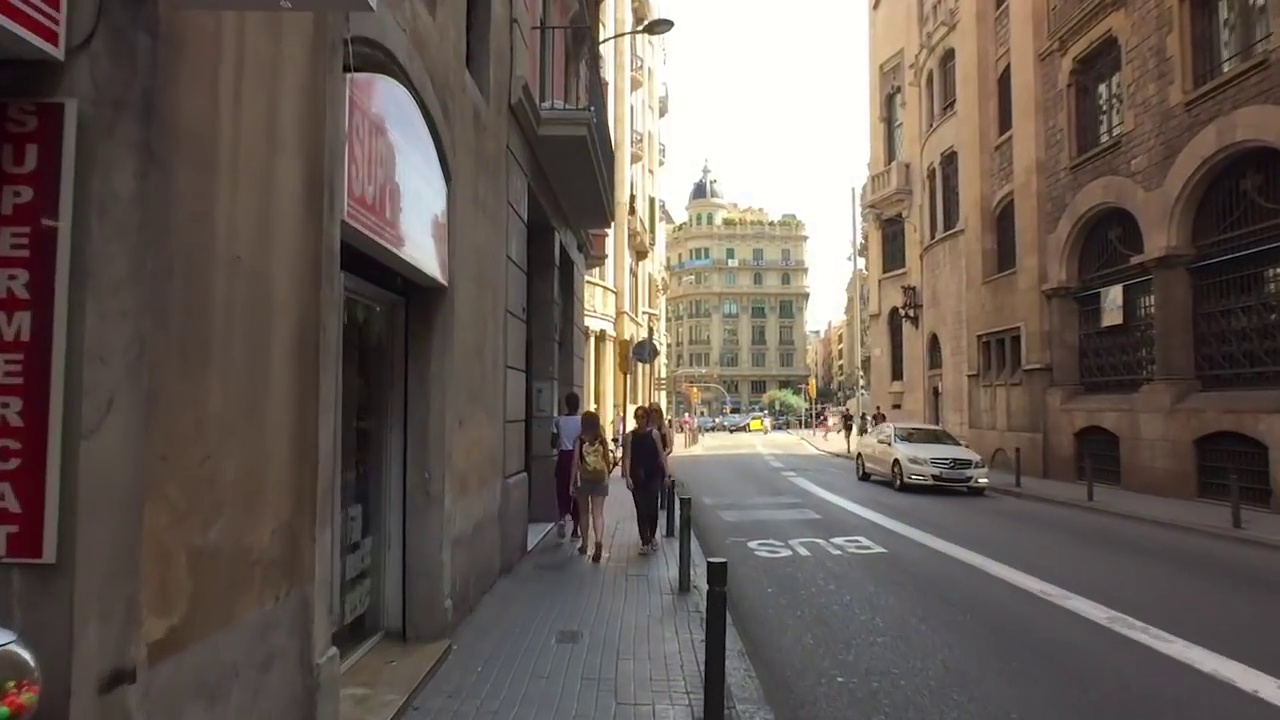

In [ ]:
black = list(data_dir.glob('walk/*'))
PIL.Image.open(str(black[0]))

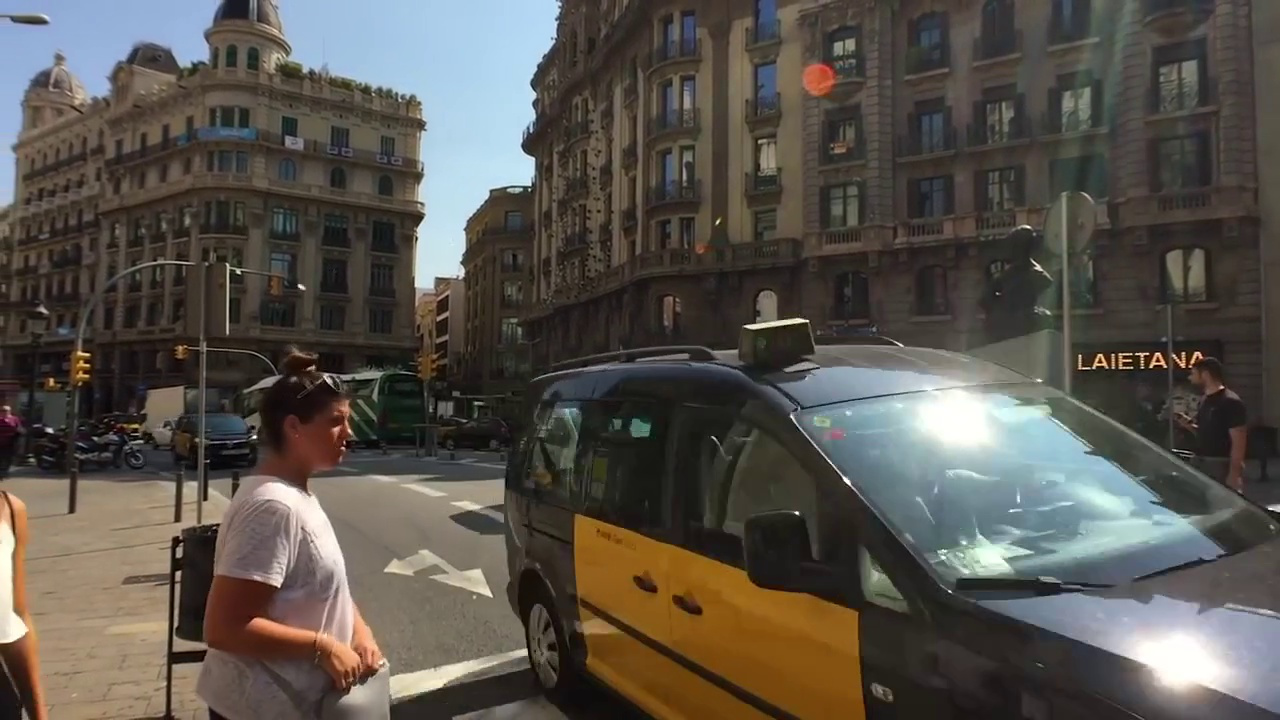

In [ ]:
PIL.Image.open(str(black[1]))

And some tulips:

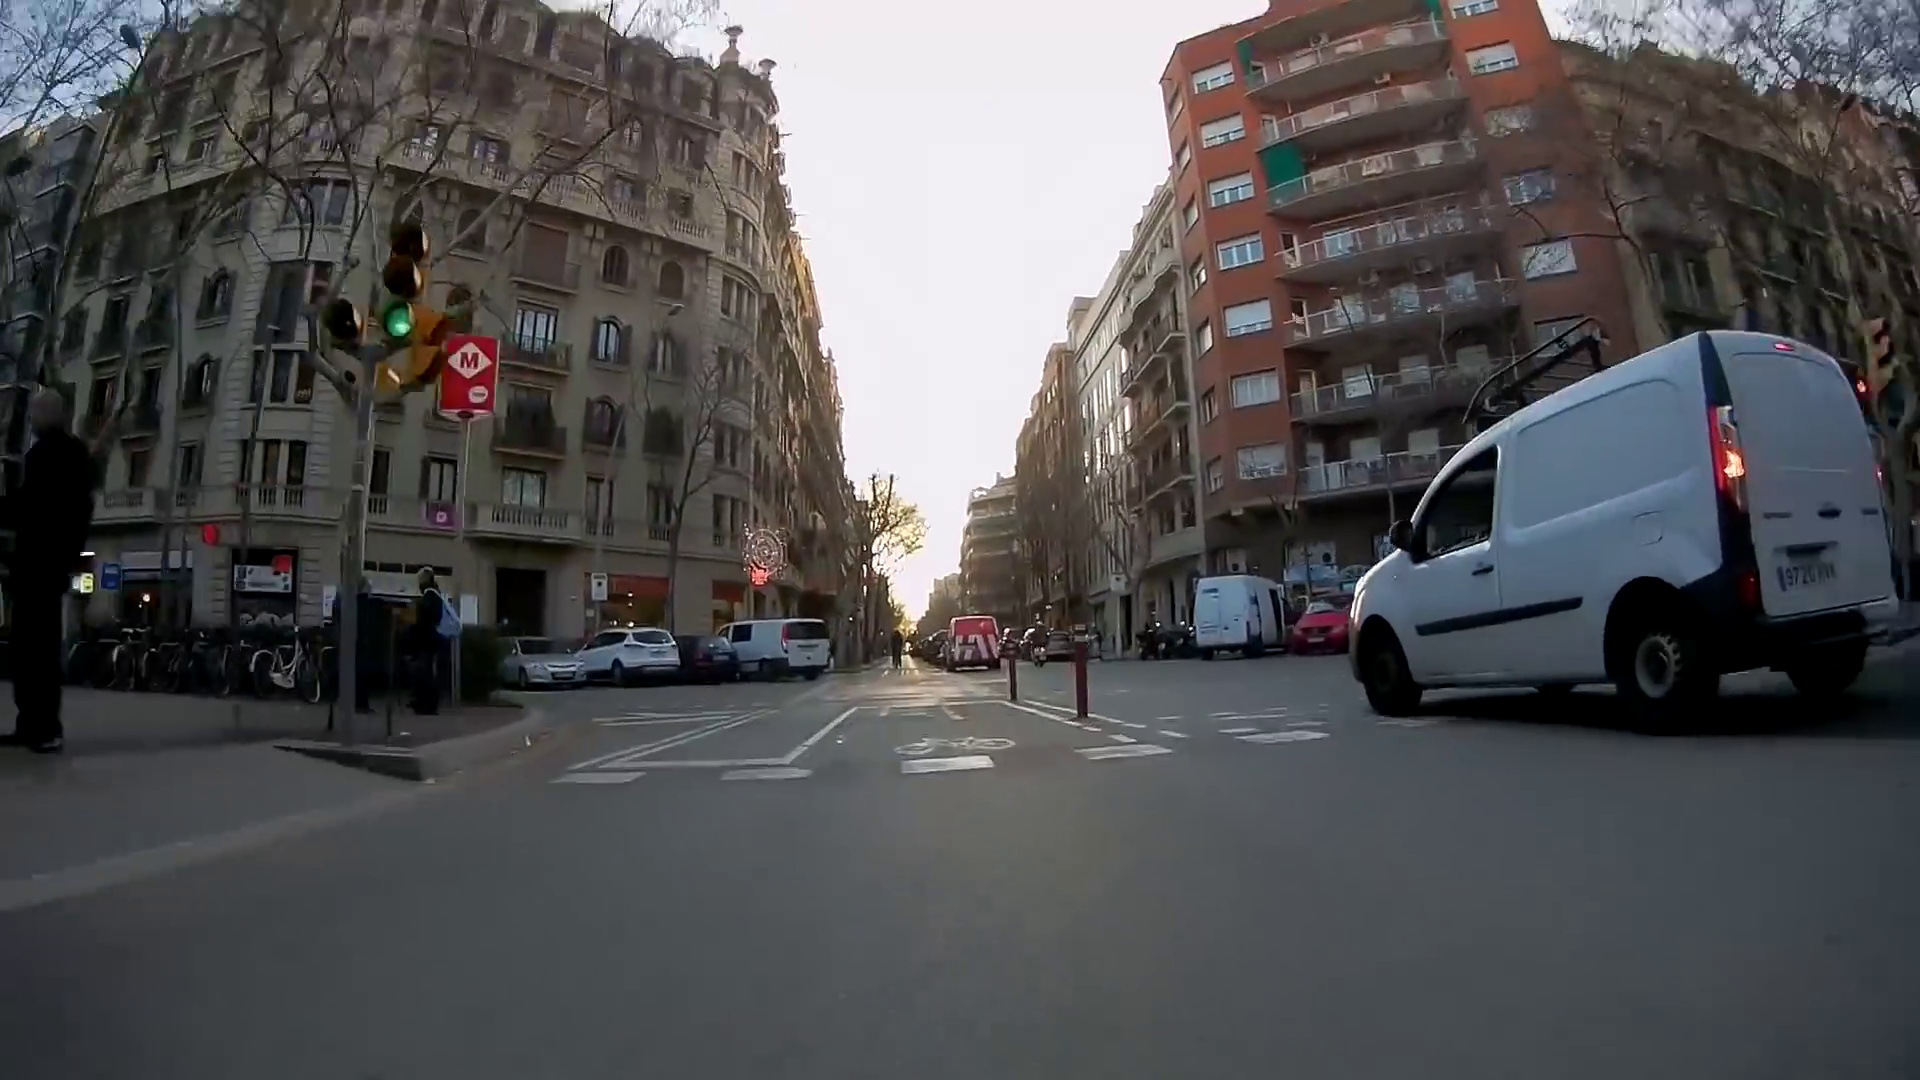

In [ ]:
qr = list(data_dir.glob('bici/*'))
PIL.Image.open(str(qr[0]))

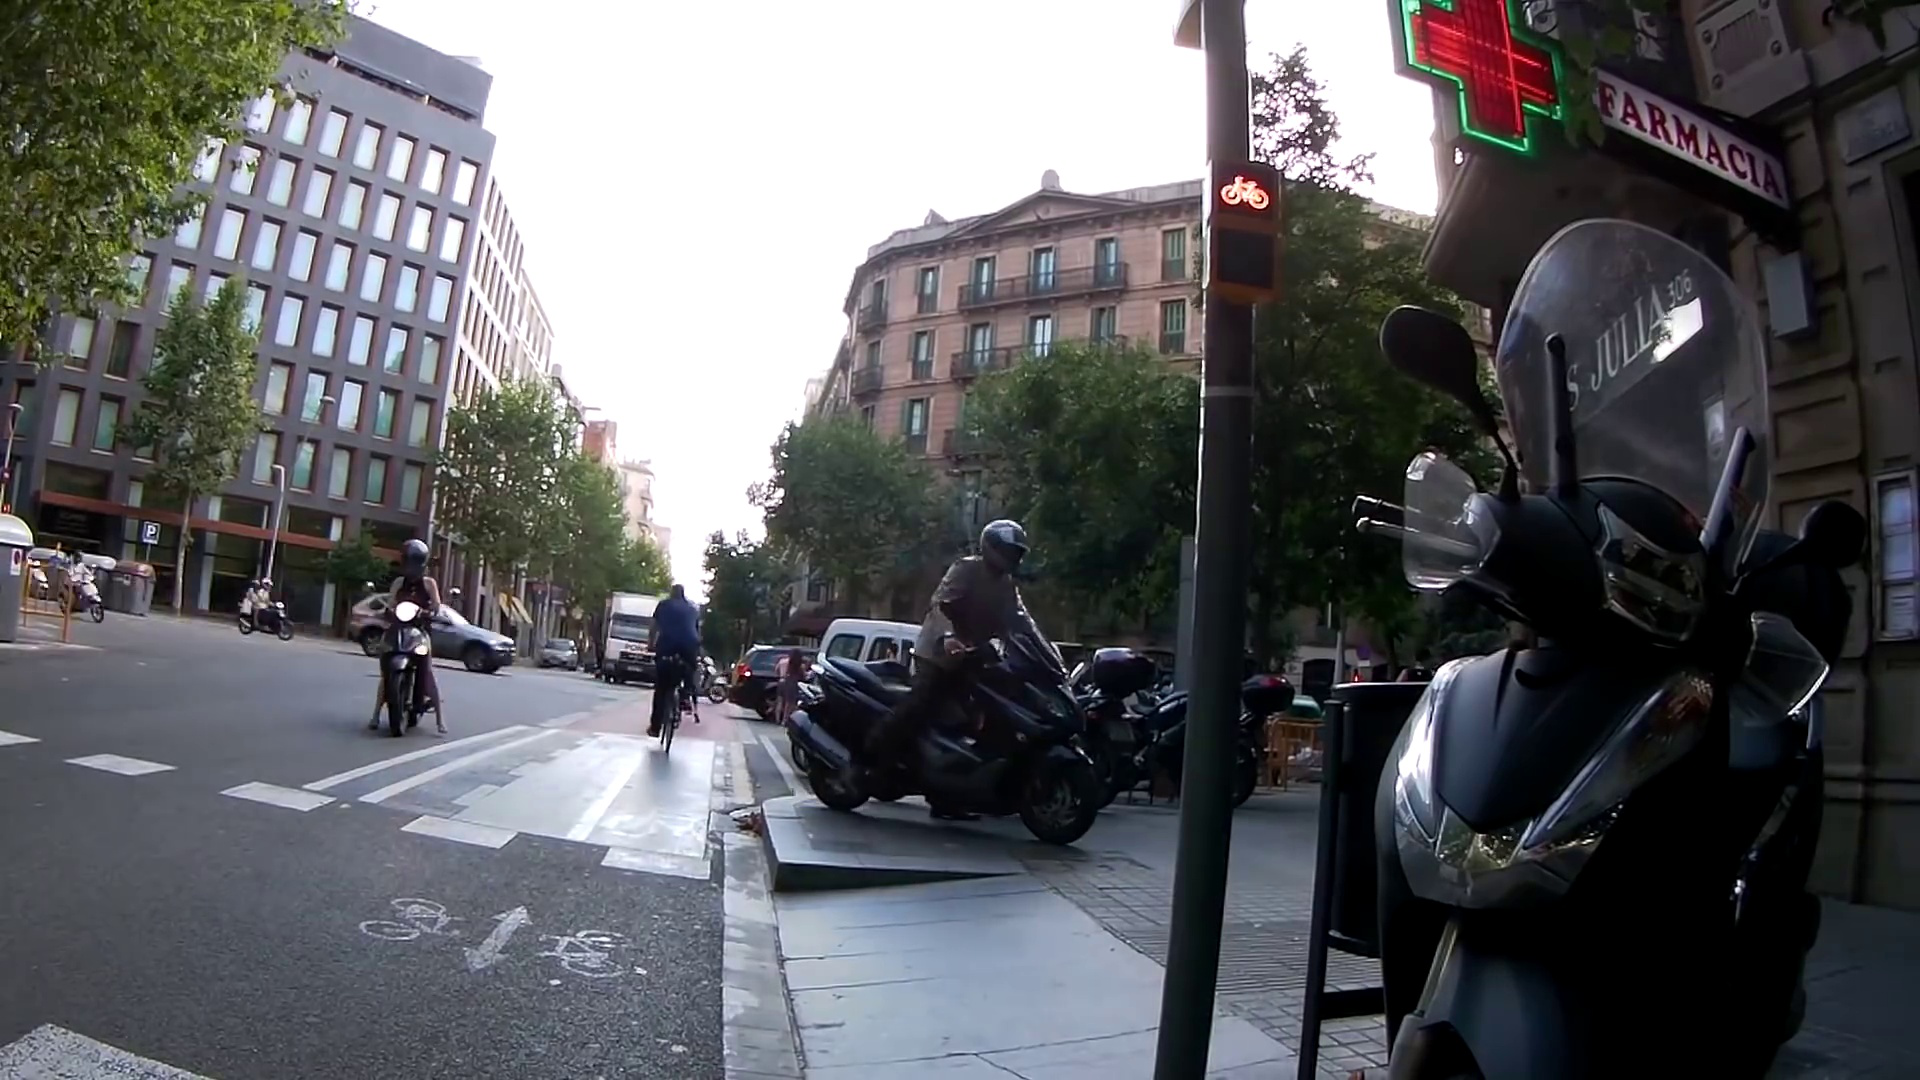

In [ ]:
PIL.Image.open(str(qr[1]))

# Load using keras.preprocessing



## Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 250
img_width = 250
#width = height

It's good practice to use a validation split when developing your model. We will use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 786 files belonging to 2 classes.
Using 629 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 786 files belonging to 2 classes.
Using 157 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['bici', 'walk']


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting then using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using experimental [Keras Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/?version=nightly). These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomContrast(0.15),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.05),
  ]
)

## Dropout

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

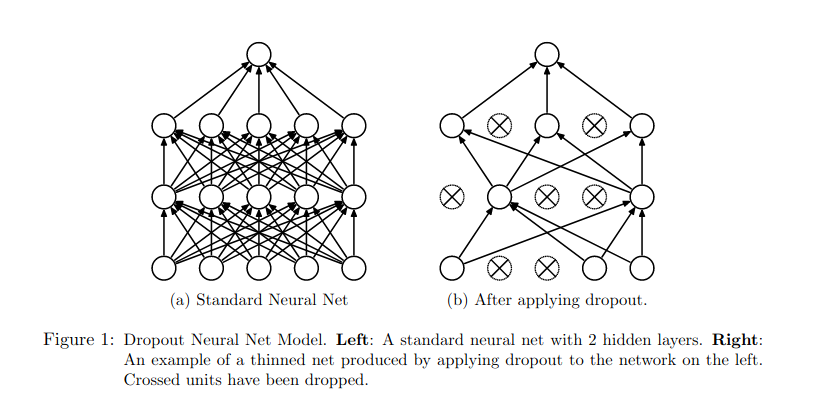

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [ ]:
num_classes = 2

# Create new model on top
inputs = keras.Input(shape=(250, 250, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(num_classes, activation="relu")(x)

model = Model(inputs, outputs)

#https://wngaw.github.io/transfer-learning-for-image-classification/ and https://keras.io/guides/transfer_learning/ 

## Compile the model

We choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 250, 250, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 250, 250, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098  

## Train the model

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
20/20 [==============================] - 335s 11s/step - loss: 0.6451 - accuracy: 0.6250 - val_loss: 0.4444 - val_accuracy: 0.8471
Epoch 2/5
20/20 [==============================] - 196s 10s/step - loss: 0.3814 - accuracy: 0.8673 - val_loss: 0.3290 - val_accuracy: 0.9172
Epoch 3/5
20/20 [==============================] - 194s 10s/step - loss: 0.2735 - accuracy: 0.9277 - val_loss: 0.2357 - val_accuracy: 0.9618
Epoch 4/5
20/20 [==============================] - 193s 10s/step - loss: 0.2117 - accuracy: 0.9304 - val_loss: 0.2078 - val_accuracy: 0.9682
Epoch 5/5
20/20 [==============================] - 192s 10s/step - loss: 0.1871 - accuracy: 0.9488 - val_loss: 0.1655 - val_accuracy: 0.9809


## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

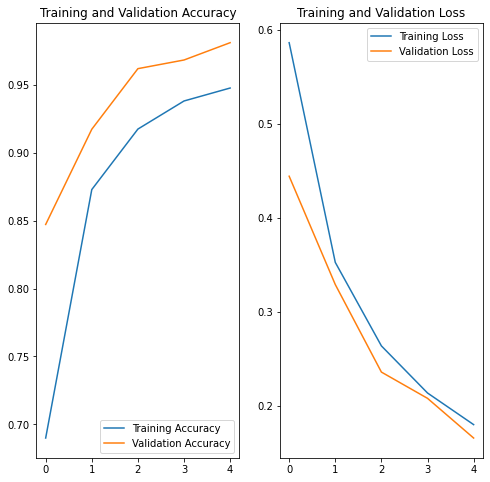

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

###Confusion Matrix


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1970: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

        bici       0.99      0.98      0.99       110
        walk       0.96      0.98      0.97        47

    accuracy                           0.98       157
   macro avg       0.97      0.98      0.98       157
weighted avg       0.98      0.98      0.98       157



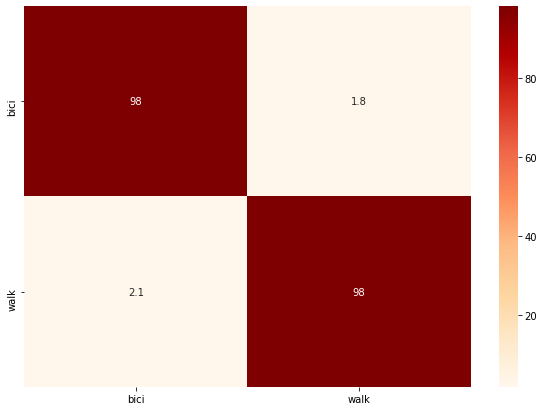

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

num_of_test_samples = 558
#Confution Matrix and Classification Report
Y_Pred = model.predict_generator(val_ds, num_of_test_samples // batch_size+1)
y_real = []
for element in val_ds.as_numpy_iterator():
  array = element[1].tolist()
  for ar in array:
    y_real.append(ar) 
for ind, res in enumerate(Y_Pred) :
  Y_Pred[ind] = tf.nn.softmax(res)
  index = np.argmax(Y_Pred[ind])
  max = Y_Pred[ind][index]
  if str(y_real[ind]) != str(index) and y_real[ind]==2 and (100*max.item())>65:
    print("Should "+str(class_names[y_real[ind]])+" but predicted: "+str(class_names[index])+" with "+str(max.item()))
print('Confusion Matrix')

y_pred = np.argmax(Y_Pred, axis=1)
array = confusion_matrix(y_real, y_pred)
prob_array = []
for ar in array:
  total = 0
  for a in ar:
    total += a
  prob_array.append(ar/total*100)

df_cm = pd.DataFrame(prob_array, index = [i for i in class_names],
              columns = [i for i in class_names])
plt.figure(figsize = (10,7))
plt.xlabel('Predicted')
plt.ylabel('True')
sn.heatmap(df_cm, annot=True,cmap="OrRd")

print('Classification Report')

print(classification_report(y_real, y_pred, target_names=class_names))


## Save model


To load our trained model into TensorFlow Serving we first need to save it in SavedModel format. This will create a protobuf file in a well-defined directory hierarchy, and will include a version number. TensorFlow Serving allows us to select which version of a model, or "servable" we want to use when we make inference requests. Each version will be exported to a different sub-directory under the given path.

In [ ]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile
MODEL_DIR = '/content/drive/My' + ' '+'Drive/SmartScooter/Zone_Classifier/new_models'
version = 1
export_path = os.path.join(MODEL_DIR, "Zones_v"+str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)



export_path = /content/drive/My Drive/SmartScooter/Zone_Classifier/new_models/Zones_v1



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:500: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/My Drive/SmartScooter/Zone_Classifier/new_models/Zones_v1/assets


In [ ]:
%cd {export_path}

!saved_model_cli show --dir . --all

/content/drive/My Drive/SmartScooter/Zone_Classifier/new_models/Zones_v1
2021-03-02 19:42:13.479525: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_3'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 250, 250, 3)
        name: serving_default_input_3:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2